In [1]:
import cartopy

* From Wikipedia:  The length of 1 minute of latitude is 1.853 km (1.151 statute miles) (1.00 nautical miles), while the length of 1 second of latitude is 30.8 m or 101 feet
* Longitude for lat 50°: ca 60km/degree

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import io

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import geojson
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import geojson

from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from pyproj import CRS

from pyproj import Transformer


class ert_geojson(object):
    """
    Import electrode coordinates from a geojson file
    """

    def __init__(self, geojson_file):
        # assert os.path.isfile(geojson_file)
        self.filename = geojson_file
        self.wgs84_points = []
        self.utm_coords = None
        
        self.load_geojson_file()
        self.summarize()

        # self.output = widgets.Output()

    def _prepare_utm_transformer(self):
        
        # First we need to get the UTM zone for our data points
        xmin = self.wgs84_points[:, 0].min()
        xmax = self.wgs84_points[:, 0].max()
        xdiff = xmax - xmin

        ymin = self.wgs84_points[:, 1].min()
        ymax = self.wgs84_points[:, 1].max()
        
        utm_crs_list = query_utm_crs_info(
            datum_name="WGS 84",
            area_of_interest=AreaOfInterest(
                west_lon_degree=xmin,
                south_lat_degree=xmax,
                east_lon_degree=ymin,
                north_lat_degree=ymax,
            ),
        )
        
        self.utm_crs = CRS.from_epsg(utm_crs_list[0].code)
        # print(utm_crs.to_wkt(pretty=True))

        # From SW Maps Homepage: All data recorded and exported by SW Maps is in the WGS84 geographic
        # coordinate system (EPSG:4326).
        self.wgs84_crs = CRS.from_string("EPSG:4326")
       
        self.transformer = Transformer.from_crs(self.wgs84_crs, self.utm_crs)
        
    def _to_utm(self):
        if self.utm_coords is not None:
            # work was already done
            return
        self._prepare_utm_transformer()    
        utm_coords = []
        for point in self.wgs84_points:
            utm_tmp = self.transformer.transform(*point[0:2])
            utm_coords += [[utm_tmp[0], utm_tmp[1], point[2]], ]
        self.utm_coords = np.array(utm_coords)

    def load_geojson_file(self):
        if isinstance(self.filename, io.BytesIO):
            self.filename.seek(0)
            self.data = geojson.load(self.filename)
        else:
            with open(self.filename, 'r') as fid:
                self.data = geojson.load(fid)
                
        self.wgs84_points = np.array(
            list(
                geojson.utils.coords(
                    self.data['features']
                )
            )
        )
        self._to_utm()

    def summarize(self):
        print('Data filename:', self.filename)
        print('Number of data points:', self.wgs84_points.shape)
        print(self.wgs84_points)

    def plot_to_map(self):
        imagery = OSM(
            cache=True,
        )
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(
            1, 1, 1, projection=imagery.crs
        )

        # try to find some sane extents based on the loaded data points
        # longitude (east-west, x-axis)
        xmin = self.wgs84_points[:, 0].min()
        xmax = self.wgs84_points[:, 0].max()
        xdiff = xmax - xmin

        ymin = self.wgs84_points[:, 1].min()
        ymax = self.wgs84_points[:, 1].max()
        ydiff = ymax - ymin
        
        extent = [
            self.wgs84_points[:, 0].min() - xdiff / 2,
            self.wgs84_points[:, 0].max() + xdiff / 2,
            self.wgs84_points[:, 1].min() - ydiff / 2,
            self.wgs84_points[:, 1].max() + ydiff / 2,
        ]
        ax.set_extent(extent, ccrs.PlateCarree())
        # ax.set_extent(extent, ccrs.UTM(32))
        #[
        # Spiekeroog
        #7.6587,
        #7.84,
        #53.75,
        #53.79R
        
        #], ccrs.PlateCarree()
        #)

        # Add the imagery to the map.
        detail = 19
        ax.add_image(imagery, detail)

        for index, point in enumerate(self.wgs84_points):
            print(point)
            ax.scatter(
                point[0],
                point[1],
                transform=ccrs.PlateCarree(),
                #transform=ccrs.OSGB(approx=False),
                s=100,
                color='k',
            )
            ax.annotate(
                '{}'.format(int(index)),
                xy=(point[0], point[1]),
                transform=ccrs.PlateCarree(),
                color='r',
                fontsize=26,
                bbox=dict(boxstyle="round", fc="0.8"),
                textcoords='offset pixels',
                xytext=(10, 25),
            )

        return fig, ax

    def plot_topography(self, relative=False):
        coords = self.utm_coords[:, :]
        if relative:
            for i in range(3):
                coords[:, i] -= coords[:, i].min()

        xy_distances = np.hstack((
            0,
            np.sqrt(
                (coords[1:, 0] - coords[0:-1, 0]) ** 2 +
                (coords[1:, 1] - coords[0:-1, 1]) ** 2
            )
        ))

        
        fig, axes = plt.subplots(1, 2)
        ax = axes[0]
        ax.plot(
            np.cumsum(xy_distances),
            coords[:, 2],
            '.-',
        )
        ax.grid()
        ax.set_xlabel('distance [m]')
        ax.set_ylabel('height [m]')
        if relative:
            ax.set_title('Relative heights', loc='left', fontsize=7)
        ax.set_title('Topography', loc='right')

        ax = axes[1]
        ax.plot(
            xy_distances
        )
        ax.grid()
        ax.set_ylabel('Electrode distances [m]')
        ax.set_xlabel('Electrode Nr')
        return fig, ax

In [4]:
import ipywidgets as widgets
import shapely
import shapely.plotting


class electrode_manager(object):
    def __init__(self, electrode_positions):
        self.el_coords_orig = electrode_positions
        self.electrode_positions = np.hstack((
            self.el_coords_orig[:, :],
            np.ones(electrode_positions.shape[0])[:, np.newaxis],
        ))
        # debug
        # self.electrode_positions[1, 3] = 0
        self.vbox = None

    def set_status_use_as_electrode(self, index, change):
        self.electrode_positions[index, 3] = int(change['new'])
        self._update_widgets()
        
    def _build_widgets(self):
        el_widgets = []
        active_electrode_index = 0
        for index, electrode in enumerate(self.electrode_positions):
            items = []
            items += [
                widgets.Label('_'),
                widgets.Button(description='Move down'),
                widgets.Button(description='Move up'),
                widgets.Checkbox(
                    value=True,
                    description='Use as electrode',
                    disabled=False,
                    indent=False
                ),
            ]

            items[1].on_click(lambda x, eindex=index: self.move_down(x, eindex))
            items[2].on_click(lambda x, eindex=index: self.move_up(x, eindex))
            
            items[3].observe(
                lambda change, eindex=index: self.set_status_use_as_electrode(eindex, change), names='value'
            )
            # print(items)
            hbox = widgets.HBox(items)
            el_widgets += [hbox]
            #if active:
            #    active_electrode_index += 1
        
        vbox = widgets.VBox(el_widgets)
        self.vbox = vbox
        self._update_widgets()
        
    def _update_widgets(self):
        active_electrode_index = 0

        for index, electrode in enumerate(self.electrode_positions):
            line = self.vbox.children[index].children
            if electrode[3] == 0:
                active = False
                line[0].value = 'Electrode -: ({}/{}/{})'.format(*electrode)
                # move down button
                line[1].disabled = True
                # move up button
                line[2].disabled = True
                # use-as-electrode checkbox
                line[3].value = False
            else:
                active = True
                line[0].value = 'Electrode {}: ({}/{}/{})'.format(active_electrode_index, *electrode)
                # move-down button
                line[1].disabled = False
                # move up button
                line[2].disabled = False
                # use-as-electrode checkbox
                line[3].value = True
                active_electrode_index += 1
    
    def set_active_state(self, index, state):
        pass
        
    def move_down(self, button, index):
        print('Moving down {} -> {}'.format(index, index + 1))
        new_position = index + 1
        if new_position >= self.electrode_positions.shape[0]:
            print('doing nothing')
            return
        self.electrode_positions = np.vstack((
            self.electrode_positions[0:index, :],
            self.electrode_positions[index + 1, :],
            self.electrode_positions[index, :],
            self.electrode_positions[index + 2:, :],
        ))
        print(self.electrode_positions)
        self._update_widgets()
        self.show()

    def move_up(self, button, index):
        print('Moving up {} -> {}'.format(index, index - 1))
        new_position = index - 1
        if new_position < 0:
            print('doing nothing')
            return
        self.electrode_positions = np.vstack((
            self.electrode_positions[0:index - 1, :],
            self.electrode_positions[index, :],
            self.electrode_positions[index - 1, :],
            self.electrode_positions[index + 1:, :],
        ))
        self._update_widgets()
        self.show()

    def show(self):
        if self.vbox is None:
            self._build_widgets()
        display(self.vbox)

    def get_electrode_positions(self):
        indices = np.where(self.electrode_positions[:, 3])
        return np.vstack((
            self.electrode_positions[indices, 0],
            self.electrode_positions[indices, 2],
        )).T



In [5]:
import crtomo
import tempfile
import os
import subprocess


class crtomo_mesh(object):
    def __init__(self, electrode_positions):
        self.electrode_positions = electrode_positions
        #print('Using electrodes:')
        #print(self.electrode_positions)

        # compute a few parameters
        self.distance_x = np.abs(
            self.electrode_positions[:, 0].max() - self.electrode_positions[:, 0].min()
        )
        self.distance_z = np.abs(
            self.electrode_positions[:, 1].max() - self.electrode_positions[:, 1].min()
        )
        self.distances = np.sqrt(
            (self.electrode_positions[1:, 0] - self.electrode_positions[:-1, 0]) ** 2 +
            (self.electrode_positions[1:, 1] - self.electrode_positions[:-1, 1]) ** 2
        )

        self.eldist_min = np.min(np.abs(np.diff(self.distances)))
        self.eldist_max = np.max(np.abs(np.diff(self.distances)))
        
        self.mesh = None
        self.gui = []

        self.output = widgets.Output()
        # used to plot the geometry
        self.output_geometry = widgets.Output()
        # used to plot the mesh
        self.output_mesh = widgets.Output()

        self._build_widgets()

    def on_widget_changed(self, change):
        self.plot_geometry()
        
    def _build_widgets(self):
        self.widgets = {
            'but_gen_mesh': widgets.Button(
                description='Generate Mesh',
            ),
            'upper_left_x': widgets.FloatText(
                value=self.electrode_positions[0, 0] - self.distance_x / 2.0,
                step=0.5,
                description='Upper left corner (X):',
            ),
            'upper_left_z': widgets.FloatText(
                value=self.electrode_positions[0, 1],
                step=0.5,
                description='Upper left corner (Z):',
            ),
            'lower_left_x': widgets.FloatText(
                value=self.electrode_positions[0, 0] - self.distance_x / 2.0,
                step=0.5,
                description='Lower left corner (X):',
            ),
            'lower_left_z': widgets.FloatText(
                value=self.electrode_positions[:, 0].min() - self.distance_z,
                step=0.5,
                description='Lower left corner (Z):',
            ),
            'upper_right_x': widgets.FloatText(
                value=self.electrode_positions[-1, 0] + self.distance_x / 2.0,
                step=0.5,
                description='Upper right corner (X):',
            ),
            'upper_right_z': widgets.FloatText(
                value=self.electrode_positions[-1, 1],
                step=0.5,
                description='Upper right corner (Z):',
            ),
            'lower_right_x': widgets.FloatText(
                value=self.electrode_positions[-1, 0] + self.distance_x / 2.0,
                step=0.5,
                description='Lower right corner (X):',
            ),
            'lower_right_z': widgets.FloatText(
                value=self.electrode_positions[:, 0].min() - self.distance_z,
                step=0.5,
                description='Lower right corner (Z):',
            ),
            'char_length_1': widgets.FloatText(
                value=self.eldist_min / 3.0,
                step=0.1,
                description='Char length 1:',
            ),
        }
        self.widgets['but_gen_mesh'].on_click(self.generate_mesh)

        self.widgets['upper_left_x'].observe(self.on_widget_changed, names='value')
        self.widgets['upper_left_z'].observe(self.on_widget_changed, names='value')
        self.widgets['lower_left_x'].observe(self.on_widget_changed, names='value')
        self.widgets['lower_left_z'].observe(self.on_widget_changed, names='value')

        self.widgets['upper_right_x'].observe(self.on_widget_changed, names='value')
        self.widgets['upper_right_z'].observe(self.on_widget_changed, names='value')
        self.widgets['lower_right_x'].observe(self.on_widget_changed, names='value')
        self.widgets['lower_right_z'].observe(self.on_widget_changed, names='value')
        
        gui = widgets.VBox([
            widgets.HBox([
                widgets.VBox(
                    [
                        widgets.HBox([
                            self.widgets['upper_left_x'],
                            self.widgets['upper_left_z'],
                        ]),
                        widgets.HBox([
                            self.widgets['lower_left_x'],
                            self.widgets['lower_left_z'],
                        ]),
                        widgets.HBox([
                            self.widgets['upper_right_x'],
                            self.widgets['upper_right_z'],
                        ]),
                        widgets.HBox([
                            self.widgets['lower_right_x'],
                            self.widgets['lower_right_z'],
                        ]),
                        self.widgets['char_length_1'],
                        self.widgets['but_gen_mesh'],      
                    ]
                ),
                self.output_geometry,
            ]),
            self.output_mesh,
        ])
        self.gui = gui

    def show(self):
        self.output.clear_output()
        with self.output:
            display(self.gui)
        display(self.output)
        self.plot_geometry()

    def plot_geometry(self):
        with plt.ioff():
            fig, ax = plt.subplots()
            
            points_all = [
                [self.widgets['upper_left_x'].value, self.widgets['upper_left_z'].value],
            ]
            for electrode in self.electrode_positions:
                points_all += [electrode]

            points_all += [
                [self.widgets['upper_right_x'].value, self.widgets['upper_right_z'].value],
                [self.widgets['lower_right_x'].value, self.widgets['lower_right_z'].value],
                [self.widgets['lower_left_x'].value, self.widgets['lower_left_z'].value],
            ]
            polygon = shapely.geometry.Polygon(points_all)
            self.polygon = polygon

            shapely.plotting.plot_polygon(polygon, ax=ax, linestyle='-')
            if polygon.is_simple:
                ax.set_title('Geometry looks valid!', loc='left')
                            # electrodes
            ax.scatter(
                self.electrode_positions[:, 0],
                self.electrode_positions[:, 1],
                label='electrodes',
            )
            # outer mesh corners
            ax.scatter(
                self.widgets['upper_left_x'].value,
                self.widgets['upper_left_z'].value,
                label='upper left',
            )
            ax.scatter(
                self.widgets['lower_left_x'].value,
                self.widgets['lower_left_z'].value,
                label='lower left',
            )
            ax.scatter(
                self.widgets['upper_right_x'].value,
                self.widgets['upper_right_z'].value,
                label='upper right',
            )
            ax.scatter(
                self.widgets['lower_right_x'].value,
                self.widgets['lower_right_z'].value,
                label='lower right',
            )
            
            ax.legend()
            ax.grid()
            self.output_geometry.clear_output()
            with self.output_geometry:
                display(fig.canvas)
            del(fig)
            
    def generate_mesh(self, button):
        print('Generating mesh')
        tempdir = tempfile.mkdtemp()
        # tempdir = 'tmp'
        print('PWD', os.getcwd())
        np.savetxt(tempdir + os.sep + 'electrodes.dat', self.electrode_positions, fmt='%.4f %.4f')

        with open(tempdir + os.sep + 'boundaries.dat', 'w') as fid:
            fid.write('{} {} {}\n'.format(
                self.widgets['upper_left_x'].value, self.widgets['upper_left_z'].value, 12
            ))
            for electrode in self.electrode_positions:
                fid.write('{} {} {}\n'.format(
                    *electrode, 12
                ))
            fid.write('{} {} {}\n'.format(
                self.widgets['upper_right_x'].value, self.widgets['upper_right_z'].value, 11
            ))
            fid.write('{} {} {}\n'.format(
                self.widgets['lower_right_x'].value, self.widgets['lower_right_z'].value, 11
            ))
            fid.write('{} {} {}\n'.format(
                self.widgets['lower_left_x'].value, self.widgets['lower_left_z'].value, 11
            ))

        with open(tempdir + os.sep + 'char_length.dat', 'w') as fid:
            fid.write('{}\n'.format(
                self.widgets['char_length_1'].value
            ))
            
        pwd = os.getcwd()
        print(pwd)
        os.chdir(tempdir)
        try:
            subprocess.call('cr_trig_create grid', shell=True)
        except Exception:
            print('Caught an exception while calling cr_trig_create')
            os.chdir(pwd)
            return
        os.chdir('grid')
        self.mesh = crtomo.crt_grid()
        os.chdir(pwd)
        self.plot_mesh()

    def plot_mesh(self):
        if self.mesh is None:
            return
        with plt.ioff():
            fig, ax = plt.subplots()
            self.mesh.plot_grid_to_ax(ax)
        with self.output_mesh:
            self.output_mesh.clear_output()
            display(fig)


# dGPS data analysis

Data filename: fake-ert GeoJSON/fake-ert_profil1.geojson
Number of data points: (10, 3)
[[  7.134937  50.690745 107.898146]
 [  7.134941  50.690749 107.920893]
 [  7.134948  50.690754 107.276712]
 [  7.134954  50.690757 107.229364]
 [  7.134957  50.690758 107.201455]
 [  7.134975  50.690765 107.321386]
 [  7.134988  50.690768 107.226436]
 [  7.134988  50.690768 107.203818]
 [  7.135023  50.690773 108.719261]
 [  7.13505   50.690777 109.862711]]
[  7.134937  50.690745 107.898146]
[  7.134941  50.690749 107.920893]
[  7.134948  50.690754 107.276712]
[  7.134954  50.690757 107.229364]
[  7.134957  50.690758 107.201455]
[  7.134975  50.690765 107.321386]
[  7.134988  50.690768 107.226436]
[  7.134988  50.690768 107.203818]
[  7.135023  50.690773 108.719261]
[  7.13505   50.690777 109.862711]


(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Electrode Nr', ylabel='Electrode distances [m]'>)

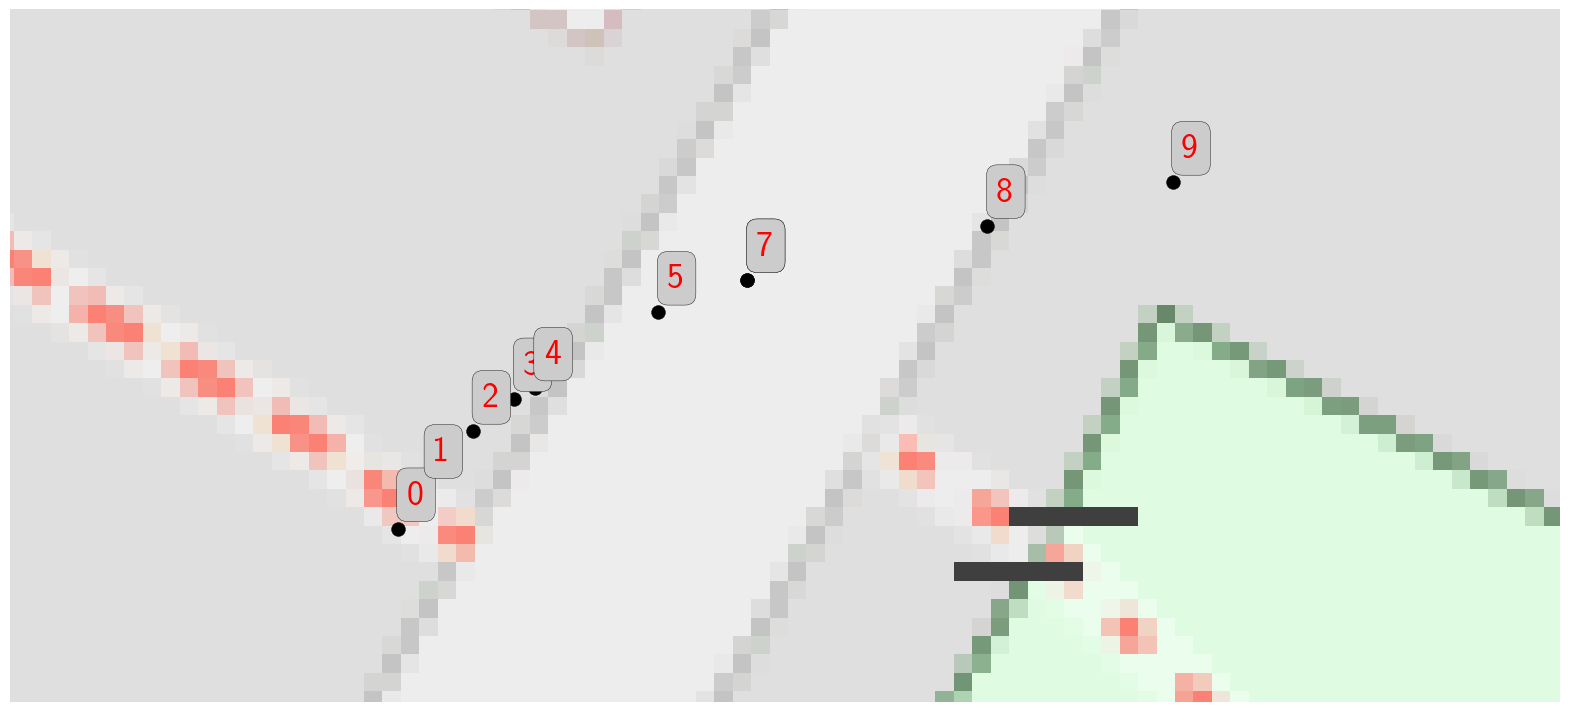

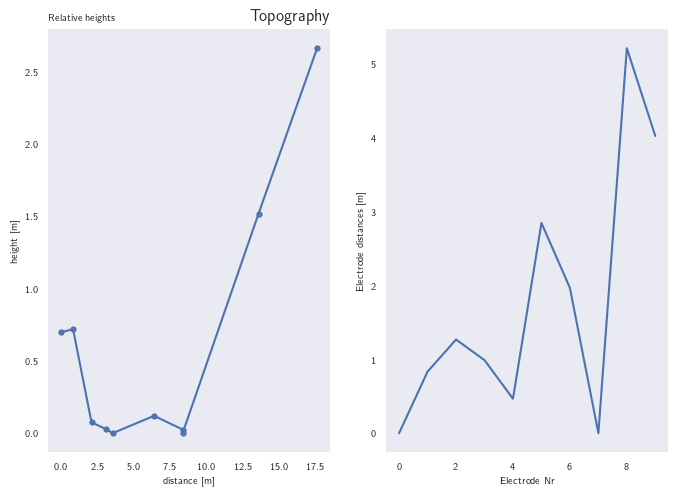

In [6]:
ert = ert_geojson('fake-ert GeoJSON/fake-ert_profil1.geojson')
fig, ax = ert.plot_to_map()
ert.plot_topography(relative=True)

In [7]:
# fake electrode positions for testing!
electrode_positions = np.array((
    (0, 0, 0),
    (1, 0, 0),
    (2, 0, 1),
    (3, 0, 1),
    (3, 0, 1),
))
manager = electrode_manager(electrode_positions)
manager.show()

In [8]:
msh_mgr = crtomo_mesh(manager.get_electrode_positions())
msh_mgr.show()

Output()

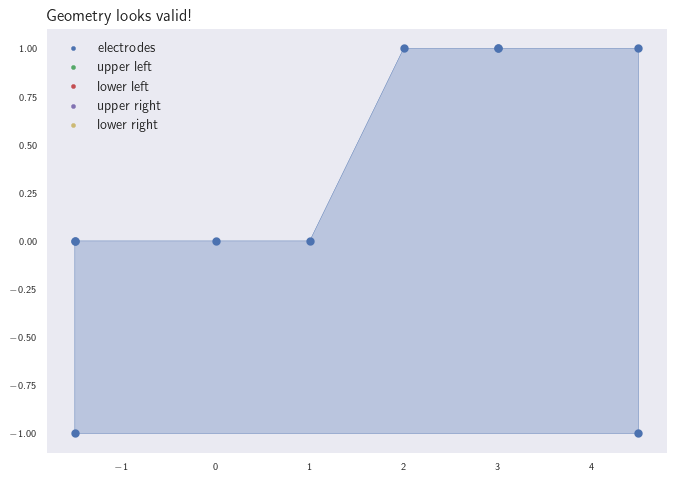

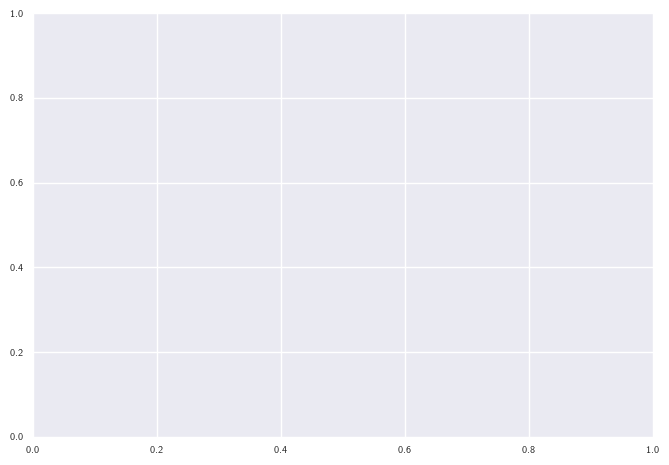

In [9]:
fig, ax = plt.subplots()

In [14]:
import zipfile
import io

class geojson_from_zip_selector(object):
    def __init__(self, filename=None):
        self.widgets = {}
        self.filename = filename
        if filename is not None:
            print('loading .zip file')
            self.zfile = zipfile.ZipFile(filename)
        else:
            self.zfile = None
        self.gui = None
        self._build_gui()

    def _zip_uploaded(self, change):
        if change['name'] == 'value':
            print(change['new'])
            cdict = change['new'][0]
            if cdict['type'] == 'application/zip' and cdict['size'] > 0:
                # try to load this as a zip
                self.zfile = zipfile.ZipFile(
                    io.BytesIO(cdict['content'])
                )
                # print('done loading .zip file')
                self._update_gui()
                
    def _selection_changed(self, change):
        if change['name'] == 'value':
            print('SELEcTION')
            print(change['new'])
            new_value = change['new']
            if new_value >= 0:
                self.widgets['but_load_gjfile'].disabled = False
            
    def _build_gui(self):
        self.widgets = {
            'upload': widgets.FileUpload(
                accept='.zip',
                multiple=False
            ),
            'gj_selector': widgets.RadioButtons(
                description='.geojson file to load:',
                disabled=False,
            ),
            'but_load_gjfile': widgets.Button(
                description='Load .geojson file',
                disabled=True,
            ),
            'output1': widgets.Output(),
            'output2': widgets.Output(),
        }

        self.gui = widgets.VBox([
            self.widgets['upload'],
            self.widgets['gj_selector'],
            self.widgets['but_load_gjfile'],
            self.widgets['output1'],
            self.widgets['output2'],
        ])
        
        self.widgets['upload'].observe(self._zip_uploaded)
        self.widgets['gj_selector'].observe(self._selection_changed)
        self.widgets['but_load_gjfile'].on_click(self.load_gjfile)

    def load_gjfile(self, button):
        print('Loading gjfile')
        # extract file into a buffer
        finfo = self.gjfiles[self.widgets['gj_selector'].value]
        print(finfo)

        buffer = io.BytesIO()
        buffer.write(self.zfile.read(finfo))
        buffer.seek(0)
        ert = ert_geojson(buffer)
        self.widgets['output1'].clear_output()
        self.widgets['output2'].clear_output()
        with self.widgets['output1']:
            with plt.ioff():
                fig, ax = ert.plot_to_map()
            display(fig)
            
        with self.widgets['output2']:
            with plt.ioff():
                fig, ax = ert.plot_topography(relative=True)
            display(fig)
        
    def _analyze_zfile(self):
        if self.zfile is None:
            return
        self.gjfiles = []
        for info in self.zfile.filelist:
            if info.file_size > 0 and info.filename.endswith('.geojson'):
                self.gjfiles += [info]

    def _update_gui(self):
        if self.zfile is None:
            # nothing to do
            return
        self._analyze_zfile()
        options = [(x.filename, index) for index, x in enumerate(self.gjfiles)]
        self.widgets['gj_selector'].options = options
        self.widgets['gj_selector'].value = None

    def show(self):
        self._update_gui()
        display(self.gui)

gjsel = geojson_from_zip_selector('fake-ert GeoJSON.zip')
gjsel.show()
        

loading .zip file


In [11]:
rb = widgets.RadioButtons(
                description='.geojson file to load:',
                disabled=False
            )

In [12]:
rb.value is None

True